In [ ]:
from google.colab import files

# This will prompt you to choose a file from your computer
uploaded = files.upload()


Saving bbc-news-data.csv to bbc-news-data.csv
Saving bbc-text.csv to bbc-text.csv


In [ ]:
 #Install required libraries
!pip install transformers torch pandas scikit-learn numpy tqdm


In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load the dataset
df = pd.read_csv('bbc-text.csv')

# Ensure the dataset has the required columns
assert 'text' in df.columns and 'category' in df.columns, "Dataset must have 'text' and 'category' columns"

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['category'])

# Save label encoder classes for later use
label_classes = label_encoder.classes_
num_labels = len(label_classes)  # Dynamically set number of labels

# Verify that all labels are valid
valid_labels = ['business', 'entertainment', 'politics', 'sport', 'tech']
assert all(label in valid_labels for label in df['category'].unique()), "Labels must be one of: " + ", ".join(valid_labels)

# Split dataset into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print('Training data shape:', train_df.shape)
print('Test data shape:', test_df.shape)

# Custom Dataset Class
class NewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.texts = dataframe['text'].values
        self.labels = dataframe['label_encoded'].values
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_dataset = NewsDataset(train_df, tokenizer)
test_dataset = NewsDataset(test_df, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize model with dynamic number of labels
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print('Model loaded to:', device)

# Training parameters
epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
model.train()
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f'Average training loss: {avg_loss:.4f}')

# Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

# Inference function
def classify_news(text):
    model.eval()
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    return label_classes[prediction]

# Example inference
sample_text = 'Tesla shares surge after strong quarterly earnings'
predicted_category = classify_news(sample_text)
print(f'Input: {sample_text}')
print(f'Predicted Category: {predicted_category}')

# Save model and tokenizer
model.save_pretrained('newsbert_model')
tokenizer.save_pretrained('newsbert_model')

# Save label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print('Model and tokenizer saved.')

Training data shape: (1780, 3)
Test data shape: (445, 3)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to: cuda
Epoch 1/3


100%|██████████| 223/223 [00:40<00:00,  5.52it/s]


Average training loss: 0.4582
Epoch 2/3


100%|██████████| 223/223 [00:40<00:00,  5.53it/s]


Average training loss: 0.0614
Epoch 3/3


100%|██████████| 223/223 [00:46<00:00,  4.75it/s]


Average training loss: 0.0339


100%|██████████| 56/56 [00:05<00:00, 11.09it/s]


Test Accuracy: 0.9685
Input: Tesla shares surge after strong quarterly earnings
Predicted Category: business
Model and tokenizer saved.


In [ ]:
# Testing code for the trained BERT model

# Load the saved model, tokenizer, and label encoder
model = BertForSequenceClassification.from_pretrained('newsbert_model')
tokenizer = BertTokenizer.from_pretrained('newsbert_model')
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Define the dataset class (same as in training)
class NewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.texts = dataframe['text'].values
        self.labels = dataframe['label_encoded'].values
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load the dataset for batch testing
df = pd.read_csv('bbc-text.csv')

# Ensure the dataset has the required columns
assert 'text' in df.columns and 'category' in df.columns, "Dataset must have 'text' and 'category' columns"

# Encode labels (using the loaded label encoder to ensure consistency)
df['label_encoded'] = label_encoder.transform(df['category'])

# Split dataset into train and test (same split as training for consistency)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create test dataset and data loader
test_dataset = NewsDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Batch Testing: Evaluate model on test set
def evaluate_model():
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

# Single Input Testing: Classify a new text input
def classify_news(text):
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    return label_encoder.inverse_transform([prediction])[0]

# Run batch evaluation
print("Running batch evaluation on test set...")
evaluate_model()

# Test with example inputs
test_texts = [
    "Tesla shares surge after strong quarterly earnings",
    "New blockbuster movie breaks box office records",
    "Government announces new policy on immigration",
    "Team wins championship in stunning upset",
    "New smartphone technology unveiled at trade show"
]

print("\nTesting single inputs:")
for text in test_texts:
    predicted_category = classify_news(text)
    print(f'Input: {text}')
    print(f'Predicted Category: {predicted_category}\n')

# Interactive testing loop
print("Interactive Testing: Enter your own text to classify (type 'exit' to quit)")
while True:
    user_input = input("Enter text: ")
    if user_input.lower() == 'exit':
        break
    predicted_category = classify_news(user_input)
    print(f'Predicted Category: {predicted_category}\n')

Running batch evaluation on test set...


Evaluating: 100%|██████████| 56/56 [00:05<00:00, 10.85it/s]


Test Accuracy: 0.9685

Testing single inputs:
Input: Tesla shares surge after strong quarterly earnings
Predicted Category: business

Input: New blockbuster movie breaks box office records
Predicted Category: entertainment

Input: Government announces new policy on immigration
Predicted Category: politics

Input: Team wins championship in stunning upset
Predicted Category: sport

Input: New smartphone technology unveiled at trade show
Predicted Category: tech

Interactive Testing: Enter your own text to classify (type 'exit' to quit)
Enter text: exit


Running batch evaluation on test set...


Evaluating: 100%|██████████| 56/56 [00:10<00:00,  5.37it/s]



Test Accuracy: 0.9685

Confusion Matrix (Raw Counts):
[[94  1  3  0  3]
 [ 1 79  0  0  1]
 [ 3  0 80  0  0]
 [ 0  0  1 97  0]
 [ 0  0  0  1 81]]

Confusion Matrix (with labels):
                      business  entertainment       politics          sport           tech
       business             94              1              3              0              3
  entertainment              1             79              0              0              1
       politics              3              0             80              0              0
          sport              0              0              1             97              0
           tech              0              0              0              1             81

Normalized Confusion Matrix (Percentages):


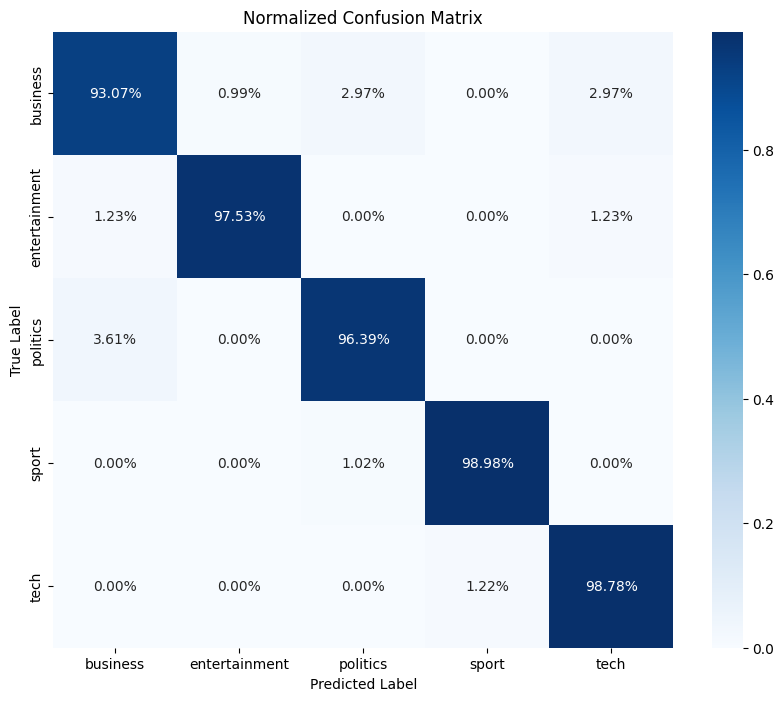


Classification Report:
               precision    recall  f1-score   support

     business     0.9592    0.9307    0.9447       101
entertainment     0.9875    0.9753    0.9814        81
     politics     0.9524    0.9639    0.9581        83
        sport     0.9898    0.9898    0.9898        98
         tech     0.9529    0.9878    0.9701        82

     accuracy                         0.9685       445
    macro avg     0.9684    0.9695    0.9688       445
 weighted avg     0.9687    0.9685    0.9685       445


Per-Class Accuracy:
       business: 0.9307
  entertainment: 0.9753
       politics: 0.9639
          sport: 0.9898
           tech: 0.9878

ROC-AUC Score (One-vs-Rest): 0.9975
Log Loss: 0.1452


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


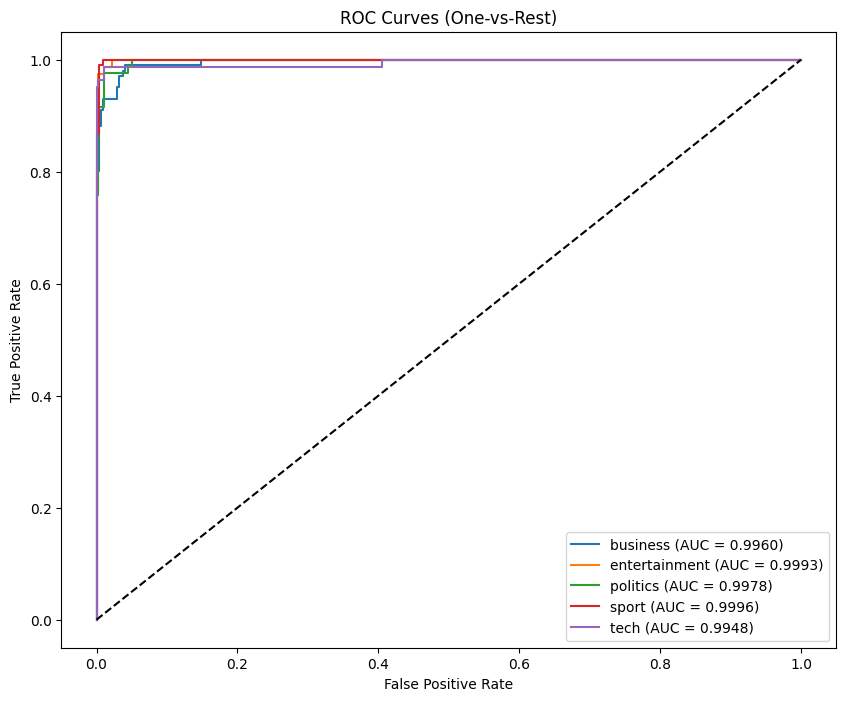

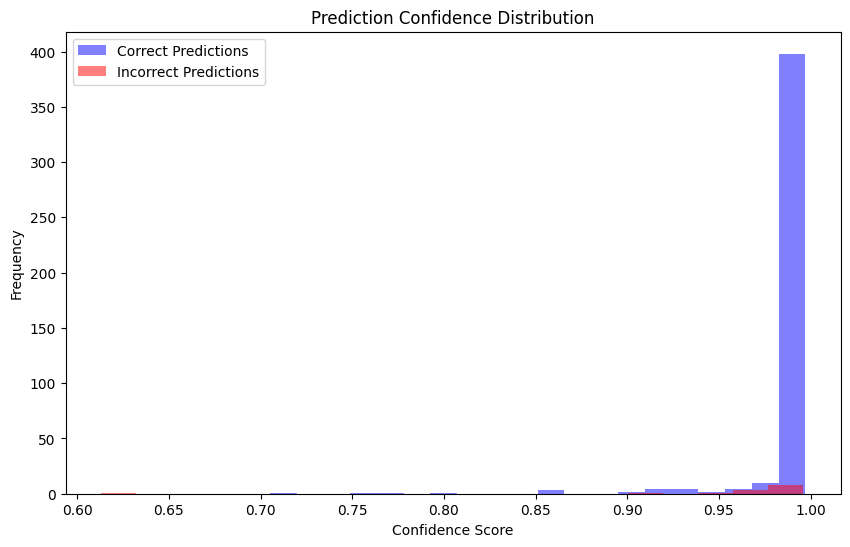


Misclassified Examples (Top 5):
Example 1:
Text: id theft surge hits us consumers almost a quarter of a million us consumers complained of being targ...
True Label: business
Predicted Label: tech

Example 2:
Text: minimum wage increased to £5.05 the minimum wage will rise in october  benefiting more than 1m peopl...
True Label: politics
Predicted Label: business

Example 3:
Text: report attacks defence spending the ministry of defence has been criticised over the soaring spendin...
True Label: politics
Predicted Label: business

Example 4:
Text: fears raised over ballet future fewer children in the uk are following in the dainty footsteps of da...
True Label: entertainment
Predicted Label: tech

Example 5:
Text: emi shares hit by profit warning shares in music giant emi have sunk by more than 16% after the firm...
True Label: business
Predicted Label: entertainment



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, log_loss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import pandas as pd

# Batch Testing: Evaluate model on test set
def evaluate_model():
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []
    misclassified_examples = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Evaluating")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
            probabilities = F.softmax(outputs.logits, dim=1)  # Get softmax probabilities
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Collect predictions, labels, and probabilities
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

            # Collect misclassified examples
            for i in range(len(labels)):
                if predictions[i] != labels[i]:
                    text = test_df.iloc[batch_idx * 8 + i]['text'][:100]  # First 100 chars for brevity
                    misclassified_examples.append({
                        'text': text,
                        'true_label': label_encoder.classes_[labels[i]],
                        'predicted_label': label_encoder.classes_[predictions[i]]
                    })

    # Calculate accuracy
    accuracy = correct / total
    print(f'\nTest Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("\nConfusion Matrix (Raw Counts):")
    print(cm)

    # Display confusion matrix with labels
    label_names = label_encoder.classes_
    print("\nConfusion Matrix (with labels):")
    print(f"{'':>15}", end="")
    for label in label_names:
        print(f"{label:>15}", end="")
    print()
    for i, row in enumerate(cm):
        print(f"{label_names[i]:>15}", end="")
        for val in row:
            print(f"{val:>15}", end="")
        print()

    # Normalized confusion matrix (percentages)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("\nNormalized Confusion Matrix (Percentages):")
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('normalized_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=label_names, digits=4))

    # Per-class accuracy
    print("\nPer-Class Accuracy:")
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    for i, acc in enumerate(class_accuracies):
        print(f"{label_names[i]:>15}: {acc:.4f}")

    # ROC-AUC Score (One-vs-Rest)
    try:
        roc_auc = roc_auc_score(all_labels, all_probabilities, multi_class='ovr')
        print(f"\nROC-AUC Score (One-vs-Rest): {roc_auc:.4f}")
    except ValueError as e:
        print(f"\nROC-AUC Score could not be computed: {e}")

    # Log Loss
    logloss = log_loss(all_labels, all_probabilities)
    print(f"Log Loss: {logloss:.4f}")

    # ROC Curves (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(np.array(all_labels) == i, np.array(all_probabilities)[:, i])
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_score(np.array(all_labels) == i, np.array(all_probabilities)[:, i]):.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.legend()
    plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Prediction Confidence Histogram
    confidences_correct = [max(prob) for pred, label, prob in zip(all_predictions, all_labels, all_probabilities) if pred == label]
    confidences_incorrect = [max(prob) for pred, label, prob in zip(all_predictions, all_labels, all_probabilities) if pred != label]
    plt.figure(figsize=(10, 6))
    plt.hist(confidences_correct, bins=20, alpha=0.5, label='Correct Predictions', color='blue')
    plt.hist(confidences_incorrect, bins=20, alpha=0.5, label='Incorrect Predictions', color='red')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Prediction Confidence Distribution')
    plt.legend()
    plt.savefig('confidence_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Misclassification Analysis
    print("\nMisclassified Examples (Top 5):")
    for i, example in enumerate(misclassified_examples[:5]):
        print(f"Example {i+1}:")
        print(f"Text: {example['text']}...")
        print(f"True Label: {example['true_label']}")
        print(f"Predicted Label: {example['predicted_label']}\n")

# Run batch evaluation
print("Running batch evaluation on test set...")
evaluate_model()